# Librerías

In [11]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from eli5 import show_weights, show_prediction
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD

%matplotlib inline

# Datos

In [12]:
train = pd.read_csv('../data/final_train.csv')
test = pd.read_csv('../data/final_test.csv')

In [13]:
train.head()

,date_number,product_id,block_id,stock,std_stock,family_id,subfamily_id,size_id,color_id,position_max,...,N3,N5,N6,N7,N8,N9,N10,N11,N12,N13
0,0,310130,1726,1383,34.811328,0.007130,0.000598,7,1,80.0,...,250,64,61,36187,64,64,61,9,95,56
1,0,1178388,592,60,2.160247,0.049198,0.012761,4,1,19.0,...,4787,64,64,66956,64,1323,752,115,64,1749
2,0,1561460,1625,2373,55.438769,0.123964,0.023599,5,1,38.0,...,9866,64,64,49495,64,7089,2551,401,86,2261
3,0,1874414,1135,1686,20.463906,0.110784,0.016021,6,1,190.0,...,5942,64,64,31410,64,1683,466,74,64,1827
4,0,2436420,779,245,23.377339,0.025903,0.004497,5,1,NaN,...,1880,64,64,49495,64,175,98,15,137,658


In [14]:
test.head()

,date_number,product_id,block_id,stock,std_stock,family_id,subfamily_id,size_id,color_id,position_max,...,N3,N5,N6,N7,N8,N9,N10,N11,N12,N13
0,71,151926,1969,636,33.103206,0.131242,0.035875,5,1,22.0,...,2198,7,7,8113,7,1169,413,59,7,615
1,71,213413,1648,1190,36.225788,0.034750,0.003149,7,1,139.0,...,196,7,7,5145,7,42,28,4,7,80
2,71,310130,1726,442,52.809180,0.008210,0.000562,7,1,46.0,...,35,7,7,5145,7,7,7,1,7,10
3,71,455200,1400,86,6.831301,0.043185,0.007647,3,1,53.0,...,287,7,7,6391,7,63,49,7,7,75
4,71,571044,1098,416,42.178063,0.103014,0.023392,4,2,205.0,...,1036,7,7,1673,7,441,98,14,7,145


In [15]:
# drop_cols = ['sales', 'date_number', 'product_id', 'block_id',
#              'position_max', 'position_min', 'std_position', 'ratio_std_pos', 'diff_position'
#             ]

sel_cols = ['stock', 'std_stock', 'family_id', 'subfamily_id', 'size_id',
       'color_id', 'category_id', 'day', 'weekend', 'stock_lag1',
       'stock_lead1', 'std_stock_shift1', 'mean_stock_shift1',
       'min_stock_shift1', 'max_stock_shift1', 'median_stock_shift1',
       'stock_lag2', 'stock_lead2', 'std_stock_shift2', 'min_stock_shift2',
       'max_stock_shift2', 'median_stock_shift2', 'mean_stock_shift2',
       'diff_stock_lead1', 'diff_stock_lead2', 'diff_stock_lag1',
       'diff_stock_lag2', 'std_stock_shift3', 'mean_stock_shift3',
       'min_stock_shift3', 'max_stock_shift3', 'median_stock_shift3',
       'size_p_color', 'size_d_color', 'N1', 'N2', 'N3', 'N5', 'N6', 'N7', 'N8', 'N9',
       'N10', 'N11', 'N12', 'N13']

X_train = train[sel_cols]
y_train = train[['sales']]
X_test = test[sel_cols]

In [16]:
X_train.head()

,stock,std_stock,family_id,subfamily_id,size_id,color_id,category_id,day,weekend,stock_lag1,...,N3,N5,N6,N7,N8,N9,N10,N11,N12,N13
0,1383,34.811328,0.007130,0.000598,7,1,3,2,0,NaN,...,250,64,61,36187,64,64,61,9,95,56
1,60,2.160247,0.049198,0.012761,4,1,1,2,0,NaN,...,4787,64,64,66956,64,1323,752,115,64,1749
2,2373,55.438769,0.123964,0.023599,5,1,3,2,0,NaN,...,9866,64,64,49495,64,7089,2551,401,86,2261
3,1686,20.463906,0.110784,0.016021,6,1,6,2,0,NaN,...,5942,64,64,31410,64,1683,466,74,64,1827
4,245,23.377339,0.025903,0.004497,5,1,0,2,0,NaN,...,1880,64,64,49495,64,175,98,15,137,658


Estandarización de las variables para modelos lineales y redes neuronales.

In [17]:
cols_ss = ['stock', 'std_stock',
       'color_id', 'category_id', 'stock_lag1',
       'stock_lead1', 'std_stock_shift1', 'mean_stock_shift1',
       'min_stock_shift1', 'max_stock_shift1', 'median_stock_shift1',
       'stock_lag2', 'stock_lead2', 'std_stock_shift2', 'min_stock_shift2',
       'max_stock_shift2', 'median_stock_shift2', 'mean_stock_shift2',
       'diff_stock_lead1', 'diff_stock_lead2', 'diff_stock_lag1',
       'diff_stock_lag2', 'std_stock_shift3', 'mean_stock_shift3',
       'min_stock_shift3', 'max_stock_shift3', 'median_stock_shift3',
           'N1', 'N2', 'N3', 'N5', 'N6', 'N7', 'N8', 'N9',
       'N10', 'N11', 'N12', 'N13']

In [18]:
ss = StandardScaler()
ss.fit(X_train[cols_ss])
X_train[cols_ss] = ss.transform(X_train[cols_ss])
X_test[cols_ss] = ss.transform(X_test[cols_ss])

In [19]:
X_test.head()

,stock,std_stock,family_id,subfamily_id,size_id,color_id,category_id,day,weekend,stock_lag1,...,N3,N5,N6,N7,N8,N9,N10,N11,N12,N13
0,-0.109097,0.282014,0.131242,0.035875,5,-0.394119,-0.146276,3,0,NaN,...,-0.296182,-3.726844,-1.929805,-1.384708,-3.726844,0.090700,0.046195,0.043777,-1.579103,0.045027
1,0.218999,0.378338,0.034750,0.003149,7,-0.394119,-0.146276,3,0,NaN,...,-0.982882,-3.726844,-1.929805,-1.523080,-3.726844,-0.698026,-0.650395,-0.651002,-1.579103,-0.667512
2,-0.223990,0.889899,0.008210,0.000562,7,-0.394119,-0.726088,3,0,NaN,...,-1.038107,-3.726844,-1.929805,-1.523080,-3.726844,-0.722521,-0.688390,-0.688899,-1.579103,-0.760742
3,-0.434825,-0.528417,0.043185,0.007647,3,-0.394119,-0.146276,3,0,NaN,...,-0.951669,-3.726844,-1.929805,-1.464989,-3.726844,-0.683329,-0.612399,-0.613105,-1.579103,-0.674171
4,-0.239388,0.561953,0.103014,0.023392,4,0.743460,-0.146276,3,0,NaN,...,-0.694756,-3.726844,-1.929805,-1.684949,-3.726844,-0.418788,-0.523742,-0.524678,-1.579103,-0.580942


In [21]:
train_ids = X_train.index
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Matrix de correlación

In [44]:
# corr = X_train.corr()

# # plot the heatmap
# sns.heatmap(corr, 
#         xticklabels=corr.columns,
#         yticklabels=corr.columns)

# Selección de variables

In [39]:
# from sklearn.ensemble import RandomForestClassifier

In [40]:
# X_train_sample = X_train.fillna(-1).sample(frac=0.1)
# X_fit, X_val, y_fit, y_val = train_test_split(X_train_sample,
#                                               y_train.iloc[X_train_sample.index.values],
#                                               test_size=0.25,
#                                               random_state=42)

In [41]:
# params = {
#     'n_estimators': 500,
#     'criterion': 'entropy',
#     'max_depth': 10,
#     'random_state': 42,
#     'n_jobs': 8,
#     'verbose': 0,
#     'min_samples_leaf': 2,
    
# }

# rf = RandomForestClassifier(**params)

In [42]:
# rf_refit = rf.fit(X_fit, y_fit)

In [43]:
# perm = PermutationImportance(rf_refit).fit(X_val, y_val)
# show_weights(perm, feature_names=X_val.columns.tolist(), top=X_val.shape[1])

In [19]:
# X = X.fillna(-1)

# LightGBM

In [22]:
model_name = 'lgbm'

params = {'max_depth':7,
          'metric':'mae',
          'max_delta_step': 0.2,
          'n_estimators':50000,
          'learning_rate':0.1,
          'colsample_bytree':0.6,
          'objective':'regression',
          'n_jobs':8,
          'seed':42,
          'lambda_l1':0,
          'lambda_l2':0,
#           'max_bin': 14,
#           'bagging_fraction':0.8,
         }

lgb_model = lgb.LGBMRegressor(**params)

In [23]:
counter = 1
be = 0
ft_importances = np.zeros(X_train.shape[1])
full_preds = np.zeros(X_test.shape[0])

for train_index, test_index in skf.split(train_ids, y_train):
    print('--- Fold k {}:'.format(counter))

    X_fit, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_fit, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    y_val = np.log1p(y_val)
    y_fit = np.log1p(y_fit)

    lgb_model.fit(X_fit,
                  y_fit,
                  eval_set=[(X_val, y_val)],
                  verbose=1000,
                  early_stopping_rounds=50)

    ft_importances += lgb_model.feature_importances_

    be += np.expm1(lgb_model.best_score_['valid_0']['l1'])
    y_preds = np.expm1(lgb_model.predict(X_test))
    full_preds += y_preds
    y_preds = [int(round(x)) for x in y_preds]
    
    counter += 1
    

full_preds = full_preds/k
full_preds = [int(round(x)) for x in full_preds]

pr = pd.DataFrame({'predicciones_lightgbm': full_preds})
pr.to_csv('../predictions/preds_lightgbm.csv')

print('IMPORTANCIA DE LAS VARIABLES:\n')
imp = pd.DataFrame({'feature': X_train.columns, 'importance': ft_importances/k})
df_imp_sort = imp.sort_values('importance', ascending=False)
df_imp_sort

--- Fold k 1:
Training until validation scores don't improve for 50 rounds.
[1000]	valid_0's l1: 0.425826
[2000]	valid_0's l1: 0.419148
[3000]	valid_0's l1: 0.416149
Early stopping, best iteration is:
[3828]	valid_0's l1: 0.414599
--- Fold k 2:
Training until validation scores don't improve for 50 rounds.
[1000]	valid_0's l1: 0.423024
[2000]	valid_0's l1: 0.416033
[3000]	valid_0's l1: 0.413245
[4000]	valid_0's l1: 0.411954
Early stopping, best iteration is:
[4372]	valid_0's l1: 0.411508
--- Fold k 3:
Training until validation scores don't improve for 50 rounds.
[1000]	valid_0's l1: 0.426229
[2000]	valid_0's l1: 0.418652
[3000]	valid_0's l1: 0.415677
[4000]	valid_0's l1: 0.414009
Early stopping, best iteration is:
[4266]	valid_0's l1: 0.413611
--- Fold k 4:
Training until validation scores don't improve for 50 rounds.
[1000]	valid_0's l1: 0.426366
[2000]	valid_0's l1: 0.418576
[3000]	valid_0's l1: 0.415519
[4000]	valid_0's l1: 0.413884
Early stopping, best iteration is:
[4829]	valid_0's

,feature,importance
23,diff_stock_lead1,6954.0
24,diff_stock_lead2,6464.4
1,std_stock,6214.2
26,diff_stock_lag2,5788.0
25,diff_stock_lag1,5594.8
18,std_stock_shift2,5153.0
11,std_stock_shift1,4904.6
44,N12,4537.0
41,N9,4327.8
3,subfamily_id,3957.8


In [ ]:
ft_imp = df_imp_sort.feature.values.tolist()[:10]

# XGBoost

In [36]:
params = {'max_depth': 7,
          'metric':'mae',
          'n_estimators': 5000,
          'eta': 0.1,
          'colsample_bytree':0.6,
          'nthread':8,
          'seed':42,
          'objective':'reg:linear',
         }

xgb_model = xgb.XGBRegressor(**params)

In [37]:
counter = 1
be = 0
ft_importances = np.zeros(X_train.shape[1])
full_preds = np.zeros(X_test.shape[0])

for train_index, test_index in skf.split(train_ids, y_train):
    print('--- Fold k {}:'.format(counter))

    X_fit, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_fit, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    y_val = np.log1p(y_val)
    y_fit = np.log1p(y_fit)

    xgb_model.fit(X_fit,
                  y_fit,
                  eval_set=[(X_val, y_val)],
                  verbose=100,
                  early_stopping_rounds=10,
                  eval_metric='mae')

    ft_importances += xgb_model.feature_importances_

    be += np.expm1(xgb_model.best_score)
    y_preds = np.expm1(xgb_model.predict(X_test))
    full_preds += y_preds
    y_preds = [int(round(x)) for x in y_preds]

    counter += 1
    

full_preds = full_preds/k
full_preds = [int(round(x)) for x in full_preds]

pr = pd.DataFrame({'predicciones_xgboost': full_preds})
pr.to_csv('../predictions/preds_xgboost.csv')

print('IMPORTANCIA DE LAS VARIABLES:\n')
imp = pd.DataFrame({'feature': X_train.columns, 'importance': ft_importances/k})
df_imp_sort = imp.sort_values('importance', ascending=False)
df_imp_sort

--- Fold k 1:
[0]	validation_0-mae:1.3223
Will train until validation_0-mae hasn't improved in 10 rounds.
[100]	validation_0-mae:0.438918
[200]	validation_0-mae:0.42988
[300]	validation_0-mae:0.425298
[400]	validation_0-mae:0.422928
[500]	validation_0-mae:0.420918
[600]	validation_0-mae:0.419243
[700]	validation_0-mae:0.418091
Stopping. Best iteration:
[752]	validation_0-mae:0.417553

--- Fold k 2:
[0]	validation_0-mae:1.31435
Will train until validation_0-mae hasn't improved in 10 rounds.
[100]	validation_0-mae:0.435926
[200]	validation_0-mae:0.427881
[300]	validation_0-mae:0.42325
[400]	validation_0-mae:0.420892
[500]	validation_0-mae:0.419019
[600]	validation_0-mae:0.417523
[700]	validation_0-mae:0.416094
[800]	validation_0-mae:0.415271
[900]	validation_0-mae:0.414519
[1000]	validation_0-mae:0.413959
Stopping. Best iteration:
[1033]	validation_0-mae:0.413792

--- Fold k 3:
[0]	validation_0-mae:1.31514
Will train until validation_0-mae hasn't improved in 10 rounds.
[100]	validation_0

,feature,importance
1,std_stock,0.062528
23,diff_stock_lead1,0.054780
24,diff_stock_lead2,0.045341
25,diff_stock_lag1,0.041671
26,diff_stock_lag2,0.040174
0,stock,0.039916
18,std_stock_shift2,0.039540
11,std_stock_shift1,0.038582
3,subfamily_id,0.029258
41,N9,0.029172


# CatBoost

In [40]:
params = {
    'depth':7,
    'iterations':5000,
    'eval_metric':'MAE',
    'random_seed':42,
    'learning_rate':0.1,
    'thread_count':8,
    'boosting_type':'Plain',
    'bootstrap_type':'Bernoulli',
    'colsample_bylevel':0.6
}

model_cb = CatBoostRegressor(**params)

In [41]:
cat_ft = ['day']

cat_ft_id = list()
n = 0
for c in X_train.columns:
    if c in cat_ft:
        cat_ft_id.append(n)
    n += 1

In [42]:
counter = 1
be = 0
ft_importances = np.zeros(X_train.shape[1])
full_preds = np.zeros(X_test.shape[0])

for train_index, test_index in skf.split(train_ids, y_train):
    print('--- Fold k {}:'.format(counter))

    X_fit, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_fit, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    y_val = np.log1p(y_val)
    y_fit = np.log1p(y_fit)

    model_cb.fit(X_fit,
                 y_fit,
                 eval_set=[(X_val, y_val)],
                 verbose=200,
#                  cat_features=cat_ft_id,
                 early_stopping_rounds=10)

    ft_importances += model_cb.feature_importances_

    be += np.expm1(model_cb.best_score_['validation_0']['MAE'])
    y_preds = np.expm1(model_cb.predict(X_test))
    full_preds += y_preds
    y_preds = [int(round(x)) for x in y_preds]

    counter += 1
    

full_preds = full_preds/k
full_preds = [int(round(x)) for x in full_preds]

pr = pd.DataFrame({'predicciones_catboost': full_preds})
pr.to_csv('../predictions/preds_catboost.csv')

print('IMPORTANCIA DE LAS VARIABLES:\n')
imp = pd.DataFrame({'feature': X_train.columns, 'importance': ft_importances/k})
df_imp_sort = imp.sort_values('importance', ascending=False)
df_imp_sort

--- Fold k 1:
0:	learn: 1.5019662	test: 1.5092318	best: 1.5092318 (0)	total: 102ms	remaining: 8m 30s
200:	learn: 0.4496902	test: 0.4537107	best: 0.4537107 (200)	total: 6.74s	remaining: 2m 40s
400:	learn: 0.4347640	test: 0.4422003	best: 0.4422003 (400)	total: 13.3s	remaining: 2m 32s
600:	learn: 0.4253311	test: 0.4358337	best: 0.4358337 (600)	total: 19.8s	remaining: 2m 25s
800:	learn: 0.4185400	test: 0.4320621	best: 0.4320621 (800)	total: 26.4s	remaining: 2m 18s
1000:	learn: 0.4132353	test: 0.4293572	best: 0.4293536 (999)	total: 32.8s	remaining: 2m 11s
1200:	learn: 0.4083275	test: 0.4270561	best: 0.4270561 (1200)	total: 39.4s	remaining: 2m 4s
1400:	learn: 0.4040676	test: 0.4252959	best: 0.4252959 (1400)	total: 45.9s	remaining: 1m 57s
1600:	learn: 0.4003294	test: 0.4239650	best: 0.4239650 (1600)	total: 52.4s	remaining: 1m 51s
1800:	learn: 0.3966987	test: 0.4227032	best: 0.4227000 (1799)	total: 59s	remaining: 1m 44s
2000:	learn: 0.3933648	test: 0.4217409	best: 0.4217409 (2000)	total: 1m 5s

,feature,importance
23,diff_stock_lead1,23.151912
11,std_stock_shift1,11.807565
6,category_id,7.239056
18,std_stock_shift2,6.083097
25,diff_stock_lag1,4.652037
24,diff_stock_lead2,4.408841
29,min_stock_shift3,3.297967
1,std_stock,2.655528
26,diff_stock_lag2,2.349652
2,family_id,2.117068


# Keras

In [180]:
X_train_sample = X_train.fillna(-1).sample(frac=0.1)
X_fit, X_val, y_fit, y_val = train_test_split(X_train_sample,
                                              y_train.iloc[X_train_sample.index.values],
                                              test_size=0.25,
                                              random_state=42)

# y_val = np.log1p(y_val)
# y_fit = np.log1p(y_fit)

In [181]:
callbacks = [EarlyStopping(monitor='val_loss',
                           min_delta=0.0,
                           patience=3,
                           verbose=0,
                           mode='min',
                           restore_best_weights=True)]

In [182]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [183]:
estimator = KerasRegressor(build_fn=baseline_model,
                           epochs=100,
                           batch_size=256,
                           verbose=1,
                           callbacks=callbacks,
                           validation_data=(X_val, y_val))

In [184]:
model = create_baseline()

In [185]:
history = estimator.fit(X_fit, y_fit)

Train on 31354 samples, validate on 10452 samples
Epoch 1/100
31354/31354 [==============================] - 1s 21us/step - loss: 13.4573 - val_loss: 10.7097
Epoch 2/100
31354/31354 [==============================] - 0s 6us/step - loss: 10.6327 - val_loss: 10.2146
Epoch 3/100
31354/31354 [==============================] - 0s 6us/step - loss: 10.3378 - val_loss: 9.9781
Epoch 4/100
31354/31354 [==============================] - 0s 5us/step - loss: 10.1514 - val_loss: 9.8359
Epoch 5/100
31354/31354 [==============================] - 0s 5us/step - loss: 10.0166 - val_loss: 9.7235
Epoch 6/100
31354/31354 [==============================] - 0s 5us/step - loss: 9.8966 - val_loss: 9.6253
Epoch 7/100
31354/31354 [==============================] - 0s 5us/step - loss: 9.7960 - val_loss: 9.5547
Epoch 8/100
31354/31354 [==============================] - 0s 5us/step - loss: 9.6984 - val_loss: 9.4678
Epoch 9/100
31354/31354 [==============================] - 0s 5us/step - loss: 9.6101 - val_loss: 9.42

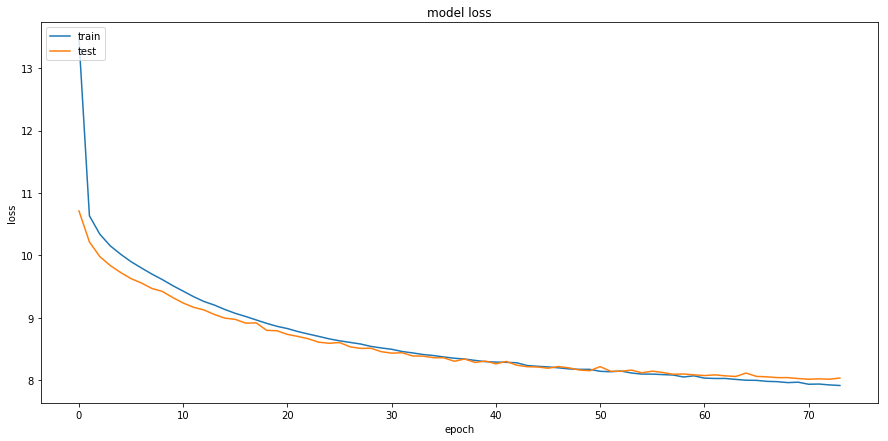

In [186]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [107]:
keras_preds = estimator.predict(X_test.fillna(-1))

62244/62244 [==============================] - 0s 2us/step


In [108]:
np.expm1(keras_preds)[:20]

array([ 17.107843  ,   6.584964  ,  22.428284  ,  11.540891  ,
        10.668456  ,  15.1289425 ,  18.780174  ,  -0.15252957,
        18.802126  ,  24.512297  ,   7.9419694 ,  38.281567  ,
         1.6043679 ,   2.1568155 , 102.12486   ,  41.492683  ,
       110.67814   ,   4.0001807 ,  15.984176  ,  19.690142  ],
      dtype=float32)

In [43]:
from sklearn.linear_model import Lasso

In [44]:
lasso = Lasso()

In [45]:
train_ids = X_train.index
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

In [46]:
counter = 1
be = 0
for train_index, test_index in skf.split(train_ids, y_train):
    print('Fold k {}\n'.format(counter))

    X_fit, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_fit, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    X_fit = X_fit.fillna(-1)
    X_val = X_val.fillna(-1)
    
#     y_val = np.log1p(y_val)
#     y_fit = np.log1p(y_fit)
    
    lasso.fit(X_fit, y_fit)
    
    print('Score en el test:',mean_absolute_error(lasso.predict(X_test.fillna(-1)), y_test),'ventas')
#     print('Score en el test:',mean_absolute_error(np.expm1(lasso.predict(X_test.fillna(-1))), y_test),'ventas')
    
    counter += 1
    
    
# print('\n\nBEST SCORE MEAN:', be / k,'SALES :)')

Fold k 1

Score en el test: 11.170156919880345 ventas
Fold k 2

Score en el test: 11.252111454322224 ventas
Fold k 3



KeyboardInterrupt: 

In [64]:
from sklearn.model_selection import TimeSeriesSplit

In [67]:
tscv = TimeSeriesSplit(n_splits=5)

In [68]:
counter = 1
be = 0
for train_index, test_index in tscv.split(X):
    X_fit, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
    y_fit, y_val = y.iloc[train_index], y.iloc[test_index]
    
#     y_val = np.log1p(y_val)
#     y_fit = np.log1p(y_fit)
    
    
    lgb_model.fit(X_fit,
                  y_fit,
                  eval_set=[(X_val, y_val)],
                  verbose=1000,
                  early_stopping_rounds=20)


#     be += np.expm1(lgb_model.best_score_['valid_0']['l1'])
    be += lgb_model.best_score_['valid_0']['l1']
    
#     print('Score en el test:',mean_absolute_error(lgb_model.predict(X_test), y_test),'ventas')
#     print('Score en el test:',mean_absolute_error(np.expm1(lgb_model.predict(X_test)), y_test),'ventas')
    
    counter += 1

Training until validation scores don't improve for 20 rounds.
[1000]	valid_0's l1: 14.9035
[2000]	valid_0's l1: 14.148
[3000]	valid_0's l1: 13.7446
Early stopping, best iteration is:
[3494]	valid_0's l1: 13.6114
Training until validation scores don't improve for 20 rounds.
[1000]	valid_0's l1: 12.3938
[2000]	valid_0's l1: 11.7195
[3000]	valid_0's l1: 11.3735
Early stopping, best iteration is:
[3420]	valid_0's l1: 11.2791
Training until validation scores don't improve for 20 rounds.
[1000]	valid_0's l1: 10.2273
Early stopping, best iteration is:
[1032]	valid_0's l1: 10.1833
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[823]	valid_0's l1: 9.79996
Training until validation scores don't improve for 20 rounds.
[1000]	valid_0's l1: 8.96911
Early stopping, best iteration is:
[1033]	valid_0's l1: 8.93757
